In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [15]:
def plot_result(result,start_from=1,period=20,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period+1],columns=result.summary.tables[1].data[0])
    summary_table["Time"]=np.array(list(range(-5,period-5+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()

In [16]:
df=pd.read_csv("../data/merged/len3_ship_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [17]:
## processing
df_columns = df.columns # 列名をリストとして取得
import re

# 正規表現パターンを作成します
pattern = r'id|^elasped_(m[0-5]|[0-9]|1\d|20)$'

# 列名のリストを作成します
column_names = [col for col in df_columns if re.search(pattern, col)]

# 列名のリストを表示します
print(column_names)
rest_columns=["year","generic_per"]
column_names=rest_columns+column_names
# try:
#     column_names.remove("elasped_m1")
# except:
#     1

try:
    column_names.remove("elasped")
except:
    1
try:
    column_names.remove("id")
except:
    1
try:
    column_names.remove("id_114")
except:
    1
# column_names

['id', 'elasped_m5', 'elasped_m4', 'elasped_m3', 'elasped_m2', 'elasped_m1', 'elasped_0', 'elasped_1', 'elasped_2', 'elasped_3', 'elasped_4', 'elasped_5', 'elasped_6', 'elasped_7', 'elasped_8', 'elasped_9', 'elasped_10', 'elasped_11', 'elasped_12', 'elasped_13', 'elasped_14', 'elasped_15', 'elasped_16', 'elasped_17', 'elasped_18', 'elasped_19', 'elasped_20', 'id_114', 'id_121', 'id_123', 'id_124', 'id_131', 'id_132', 'id_211', 'id_217', 'id_218', 'id_222', 'id_223', 'id_224', 'id_225', 'id_229', 'id_231', 'id_232', 'id_235', 'id_239', 'id_245', 'id_252', 'id_259', 'id_264', 'id_265', 'id_279', 'id_313', 'id_321', 'id_332', 'id_339', 'id_391', 'id_399', 'id_441', 'id_449', 'id_625', 'id_629', 'id_799']


In [18]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"]+0.001)
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"]+0.001)
df["year_trend"]=df["year"]-2008

In [19]:
df=df.set_index(["id","year"])
df.info()
# make this to paneldata
df=PanelData(df)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 386 entries, (114, 2008) to (799, 2021)
Columns: 110 entries, efficacy to year_trend
dtypes: float64(14), int64(92), object(4)
memory usage: 334.5+ KB


(184, 14, 30)

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

                          PanelOLS Estimation Summary                           
Dep. Variable:                 rx_dom   R-squared:                        0.1043
Estimator:                   PanelOLS   R-squared (Between):              0.3648
No. Observations:                 386   R-squared (Within):               0.0876
Date:                Wed, Aug 23 2023   R-squared (Overall):              0.3495
Time:                        11:07:28   Log-likelihood                   -7311.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.7854
Entities:                          30   P-value                           0.0192
Avg Obs:                       12.867   Distribution:                  F(21,322)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             644.14
                            

C:\Users\hakos\AppData\Local\Temp\ipykernel_2384\2956334772.py:7: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


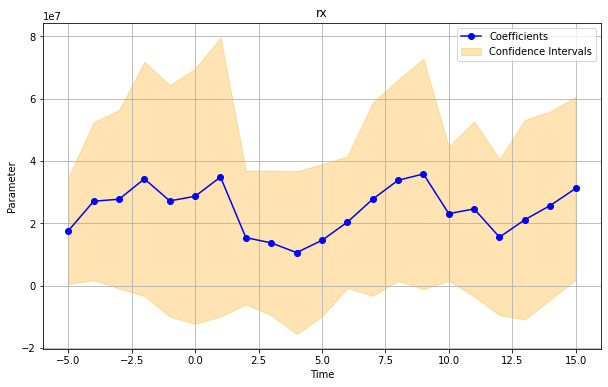

In [20]:
formula="rx_dom ~ year_trend+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_rx_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="rx",title="rx")

C:\Users\hakos\AppData\Local\Temp\ipykernel_2384\3797523648.py:8: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
elasped_m5     0.0659     0.0473     1.3944     0.1642     -0.0271      0.1590
elasped_m4     0.0861     0.0482     1.7875     0.0748     -0.0087      0.1808
elasped_m3     0.1390     0.0544     2.5520     0.0112      0.0318      0.2461
elasped_m2     0.0937     0.0642     1.4577     0.1459     -0.0327      0.2201
elasped_m1     0.0539     0.0593     0.9083     0.3644     -0.0629      0.1707
elasped_0      0.0857     0.0731     1.1717     0.2422     -0.0582      0.2295
elasped_1      0.1410     0.0773     1.8243     0.0690     -0.0111      0.2931
elasped_2      0.1058     0.0890     1.1885     0.2355     -0.0694      0.2810
elasped_3      0.0789     0.0813     0.9702     0.3327     -0.0811      0.2388
elasped_4      0.0565     0.0809     0.6988     0.48

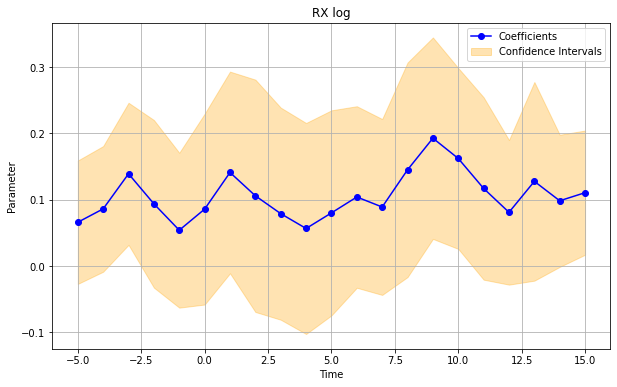

In [21]:
# take log
formula="log_rx_dom ~ year_trend+ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_rx_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log",title="RX log")

### OTC

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\hakos\AppData\Local\Temp\ipykernel_2384\2364514076.py:8: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

year_trend, generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
elasped_m5     5.886e+06  6.407e+06     0.9187     0.3590  -6.723e+06    1.85e+07
elasped_m4     7.767e+05  1.277e+06     0.6082     0.5435  -1.736e+06    3.29e+06
elasped_m3     1.124e+06  1.629e+06     0.6900     0.4908  -2.081e+06   4.329e+06
elasped_m2     2.993e+06  2.354e+06     1.2716     0.2045  -1.639e+06   7.625e+06
elasped_m1     1.346e+05  8.736e+05     0.1541     0.8776  -1.585e+06   1.854e+06
elasped_0     -1.456e+06   8.45e+05    -1.7236     0.0858  -3.119e+06   2.065e+05
elasped_1         9659.9  2.229e+06     0.0043     0.9965  -4.377e+06   4.396e+06
elasped_2      3.925e+04  1.785e+06     0.0220     0.9825  -3.474e+06   3.552e+06
elasped_3      4.536e+05  1.481e+06     0.3062     0.7597  -2.462e+06   3.369e+06
elasped_4     -7

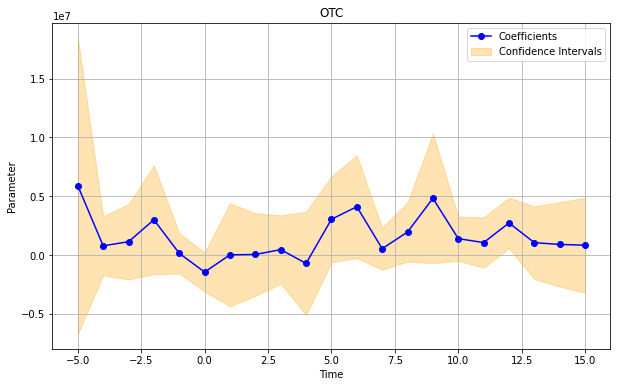

In [22]:

formula="otc_dom ~ year_trend+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version
# formula+="+stock_otc_lag"
# gemeric_per
formula+=" + generic_per"
mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="otc",title="OTC")

                          PanelOLS Estimation Summary                           
Dep. Variable:            log_otc_dom   R-squared:                        0.2371
Estimator:                   PanelOLS   R-squared (Between):          -7.549e+21
No. Observations:                 386   R-squared (Within):           -4.988e+23
Date:                Wed, Aug 23 2023   R-squared (Overall):          -7.668e+21
Time:                        11:07:29   Log-likelihood                   -214.81
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.5339
Entities:                          30   P-value                           0.0000
Avg Obs:                       12.867   Distribution:                  F(22,321)
Min Obs:                       1.0000                                           
Max Obs:                       14.000   F-statistic (robust):             76.625
                            

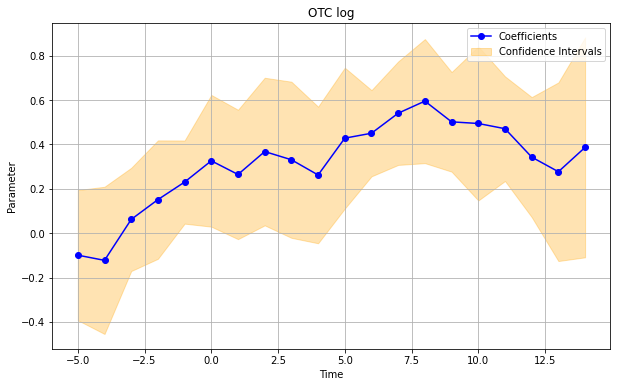

In [23]:
# take log
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# stock lag version
# formula+="+log_stock_otc_lag"

# year trend
# formula+="+year_trend"

# gemeric_per
formula+=" + generic_per"

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
plot_result(res_fe,file_name="otc_log",title="OTC log",start_from=2,period=19)

In [24]:
res_fe.cov

,elasped_m5,elasped_m4,elasped_m3,elasped_m2,elasped_m1,elasped_0,elasped_1,elasped_2,elasped_3,elasped_4,...,elasped_7,elasped_8,elasped_9,elasped_10,elasped_11,elasped_12,elasped_13,elasped_14,elasped_15,generic_per
elasped_m5,1.185562e-02,2.197235e-03,4.290659e-03,5.065173e-03,6.810631e-03,4.174457e-04,9.887235e-04,-3.910056e-04,1.648056e-03,-2.085795e-03,...,3.911528e-03,3.873192e-03,3.920048e-03,3.443984e-03,6.110865e-04,1.244718e-03,-1.709444e-03,1.084737e-03,-1.421669e-03,-2.091341e+10
elasped_m4,2.197235e-03,2.220811e-02,1.478294e-02,8.078018e-03,3.992559e-03,-1.857510e-03,6.100724e-03,1.046683e-02,1.351885e-02,1.665338e-02,...,6.010150e-03,5.063283e-03,5.410679e-03,2.376589e-03,1.308236e-02,9.218922e-03,1.328738e-02,1.754594e-02,2.393790e-02,1.354058e+10
elasped_m3,4.290659e-03,1.478294e-02,2.841749e-02,1.685295e-02,1.174279e-02,2.761325e-03,7.642337e-03,1.359286e-02,1.158947e-02,1.421777e-02,...,6.887842e-03,3.368201e-03,7.913523e-03,3.528201e-03,3.666569e-03,5.425203e-03,3.971466e-03,9.763525e-03,1.844246e-02,1.545868e+10
elasped_m2,5.065173e-03,8.078018e-03,1.685295e-02,1.397507e-02,1.178126e-02,5.490076e-03,8.966002e-03,1.106557e-02,7.570908e-03,8.459524e-03,...,5.675273e-03,4.325766e-03,7.229403e-03,3.783251e-03,4.566539e-03,5.355652e-03,2.486034e-03,7.252540e-03,1.263626e-02,6.438971e+09
elasped_m1,6.810631e-03,3.992559e-03,1.174279e-02,1.178126e-02,1.838490e-02,8.438940e-03,1.105071e-02,9.330856e-03,4.639587e-03,3.750307e-03,...,5.471202e-03,6.698863e-03,1.169173e-02,8.259105e-03,4.463497e-03,4.046244e-03,-1.092735e-03,3.611702e-03,5.111759e-03,-1.561621e+10
elasped_0,4.174457e-04,-1.857510e-03,2.761325e-03,5.490076e-03,8.438940e-03,9.069248e-03,9.201429e-03,6.024557e-03,1.270394e-04,1.095532e-03,...,3.268091e-03,5.401568e-03,7.003474e-03,5.701821e-03,4.158500e-03,2.563075e-03,-6.530190e-04,2.789619e-03,3.743482e-03,-5.932992e+09
elasped_1,9.887235e-04,6.100724e-03,7.642337e-03,8.966002e-03,1.105071e-02,9.201429e-03,2.274930e-02,1.697359e-02,5.162292e-03,8.429635e-03,...,7.650656e-03,1.006955e-02,1.604166e-02,8.187621e-03,1.603870e-02,1.041970e-02,9.208542e-03,1.715934e-02,2.210040e-02,-1.797948e+10
elasped_2,-3.910056e-04,1.046683e-02,1.359286e-02,1.106557e-02,9.330856e-03,6.024557e-03,1.697359e-02,2.194064e-02,1.532525e-02,1.865897e-02,...,7.479728e-03,8.998231e-03,1.509496e-02,7.610728e-03,1.830561e-02,1.337530e-02,1.326244e-02,2.291008e-02,3.070215e-02,-6.699988e+09
elasped_3,1.648056e-03,1.351885e-02,1.158947e-02,7.570908e-03,4.639587e-03,1.270394e-04,5.162292e-03,1.532525e-02,2.857034e-02,2.850876e-02,...,4.931895e-03,5.547273e-03,7.114301e-03,5.542235e-03,1.954297e-02,1.323452e-02,1.448173e-02,2.630357e-02,3.205882e-02,-3.510092e+08
elasped_4,-2.085795e-03,1.665338e-02,1.421777e-02,8.459524e-03,3.750307e-03,1.095532e-03,8.429635e-03,1.865897e-02,2.850876e-02,3.196614e-02,...,6.668167e-03,6.123780e-03,8.193918e-03,5.061718e-03,2.101341e-02,1.386651e-02,1.781749e-02,2.879332e-02,3.833249e-02,1.092715e+10


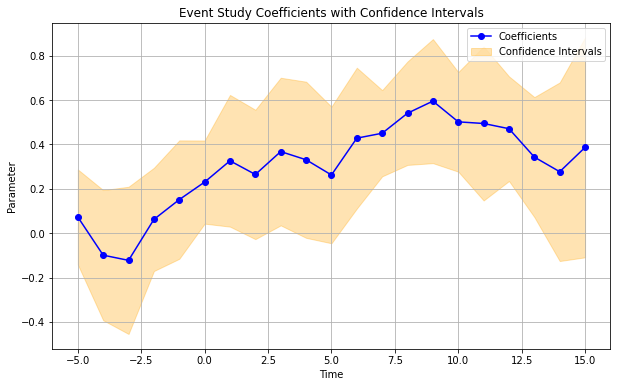

In [25]:
# 天才やん
start_from=1
period=20
summary_table=pd.DataFrame(res_fe.summary.tables[1].data[start_from:start_from+period+1],columns=res_fe.summary.tables[1].data[0])
summary_table["Time"]=np.array(list(range(-5,16)))
# make each column of summary_table numeric
summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot coefficients as points
plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

# Plot confidence intervals as error bars
# plt.errorbar(summary_table['Time'], summary_table["Parameter"],
#              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
#                    summary_table['Upper CI'] - summary_table["Parameter"]],
#              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

plt.xlabel('Time')
plt.ylabel("Parameter")
plt.title('Event Study Coefficients with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()